# Markov Chains with Applications to Unemployment and Asset Pricing

Undergraduate Computational Macro

Jesse Perla (University of British Columbia)

# Overview

## Motivation

-   Here we will introduce Markov Chains as a Markovian stochastic
    process over a discrete number of states
    -   These are useful in their own right, but are also a powerful
        tool if you discretize a continuous-state stochastic process
-   Using these, we will apply these to
    -   Introduce a simple model of unemployment and employment dynamics
    -   Risk-neutral asset pricing
-   In a future lecture these for more advanced asset-pricing examples
    including option-pricing and to explore risk-aversion

## Materials

-   Adapted from QuantEcon lectures coauthored with John Stachurski and
    Thomas J. Sargent
    -   [Finite Markov
        Chains](https://julia.quantecon.org/introduction_dynamics/finite_markov.html)
    -   [A Lake Model of Employment and
        Unemployment](https://julia.quantecon.org/multi_agent_models/lake_model.html)

In [1]:
using LinearAlgebra, Statistics, Distributions
using Plots.PlotMeasures, Plots, QuantEcon, Random
using StatsPlots, LaTeXStrings, NLsolve
default(;legendfontsize=16, linewidth=2, tickfontsize=12,
         bottom_margin=15mm)

# Markov Chains

## Discrete States

-   Consider a set of $N$ possible states of the world
-   **Markov chain**: a sequence of random variables $\{X_t\}$ on
    $\{x_1, \ldots, x_N\}$ with the [Markov
    property](https://en.wikipedia.org/wiki/Markov_property) $$
    \mathbb P ( X_{t+1} = x  \,|\, X_t )
    = \mathbb P ( X_{t+1}  = x \,|\, X_t, X_{t-1}, \ldots )
    $$
-   It will turn out that all Markov stochastic processes with a
    discrete number of states are Markov Chains and can be summarize by
    a **transition matrix**

See
[here](https://en.wikipedia.org/wiki/Continuous-time_Markov_chain#Definition)
for Continuous Time Markov Chains which replace the transition
probabilities with transition rates

## Transition Matrix

-   Summarize into a $P\in\mathbb{R}^{N\times N}$ **transition matrix**
    where $$
    P_{ij} \equiv \mathbb P ( X_{t+1} = x_j \,|\, X_t = x_i ),\quad \text{ for }i=1,\ldots N, j=1,\ldots N
    $$
-   Each row is a probability distribution for the next state ($j$)
    conditional on the current one ($i$)
    -   Hence $P_{ij}\geq 0$ and $\sum_{j=1}^N P_{ij} = 1$ for all $i$
-   The ordering of the matrix or states $x_1, \ldots x_N$ is arbitrary,
    but you need to be consistent!

## Example: Unemployed and Employed

<figure class=''>

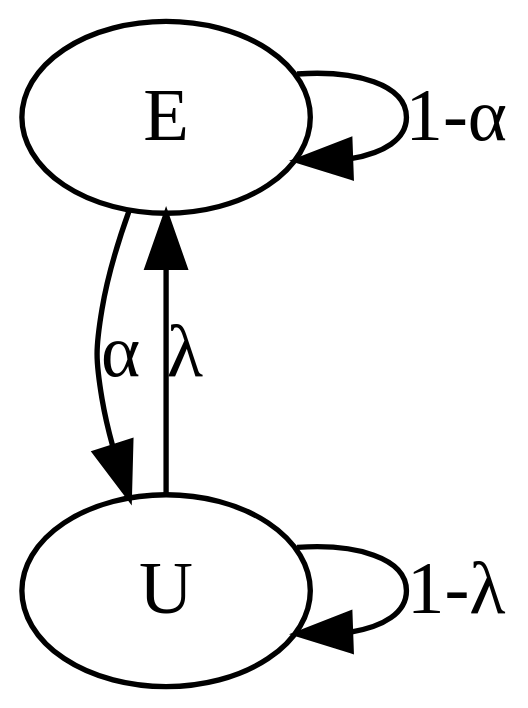

</figure>

-   $\alpha$: probability of moving from employed to unemployed
-   $\lambda$: probability of moving from unemployed to employed
-   $\mathbb{P}(X_{t+1} = U \,|\, X_t = E) = \alpha$, etc.
-   Summarize as Transition Matrix $$
    P \equiv \begin{bmatrix} 1-\alpha & \alpha\\ \lambda & 1-\lambda \end{bmatrix}
    $$

## Example: Recessions Transitions

<figure class=''>

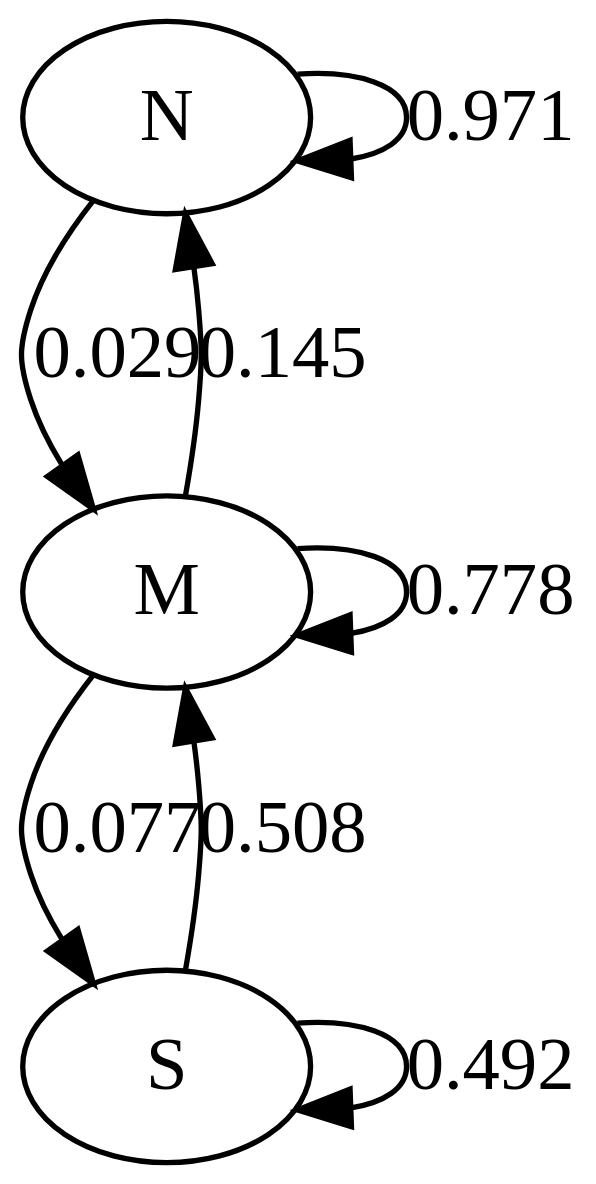

</figure>

-   States (ordered consistently):
    -   $N$: Normal Growth, $M$: Mild Recession, $S$: Severe Recession
-   Transitions empirically estimated in [Hamilton
    2005](https://julia.quantecon.org/zreferences.html#id84) $$
    P \equiv \begin{bmatrix}
       0.971 & 0.029 & 0 \\
       0.145 & 0.778 & 0.077 \\
       0 & 0.508 & 0.492
    \end{bmatrix}
    $$

## Discrete RVs

In [1]:
probs = [0.6, 0.4]
@show sum(probs) ≈ 1
d = Categorical(probs)
@show d
draws = rand(d, 4)
@show draws
# Assign associated with indices
G = [5, 20]
# access by index
@show G[draws];

sum(probs) ≈ 1 = true
d = Distributions.Categorical{Float64, Vector{Float64}}(support=Base.OneTo(2), p=[0.6, 0.4])
draws = [1, 1, 1, 1]
G[draws] = [5, 5, 5, 5]

## Simulating Markov Chains

``` julia
function simulate_markov_chain(P, X_0, T)
    N = size(P, 1)
    num_chains = length(X_0)
    P_dist = [Categorical(P[i, :])
              for i in 1:N]
    X = zeros(Int, num_chains, T+1)
    X[:, 1] .= X_0
    for t in 1:T
        for n in 1:num_chains
            X[n, t+1] = rand(P_dist[X[n, t]])
        end
    end
    return X
end
```

-   Create `Categorical` per row
-   One chain for each `X_0`
-   Simulate for each chain by:
    -   Save current index
    -   Use index to choose row
    -   Draw the new index according to that distribution

## Simulating Unemployment and Employment


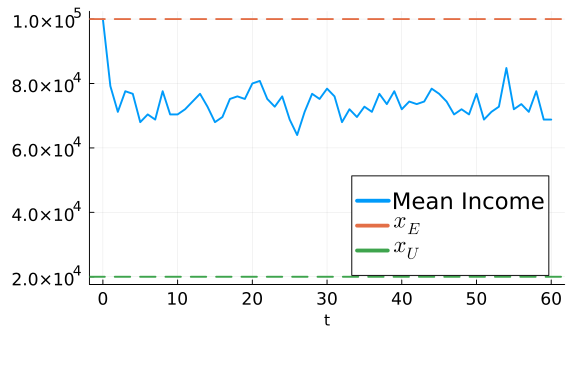

In [1]:
alpha, lambda = 0.3, 0.6
P = [1-alpha alpha; lambda 1-lambda]
G = [100000.00, 20000.00]
X_0 = ones(Int, 100)  # 100 people employed
T = 60
X = simulate_markov_chain(P, X_0, T)
X_values = G[X]  # just indexes by the X
X_mean = mean(X_values;dims=1)
plot(0:T, X_mean', xlabel="t",
     legend=:bottomright, label="Mean Income",
     size=(600, 400))
hline!([G[1]]; label=L"x_E", linestyle=:dash)
hline!([G[2]]; label=L"x_U", linestyle=:dash)

## Distribution of Future Wages


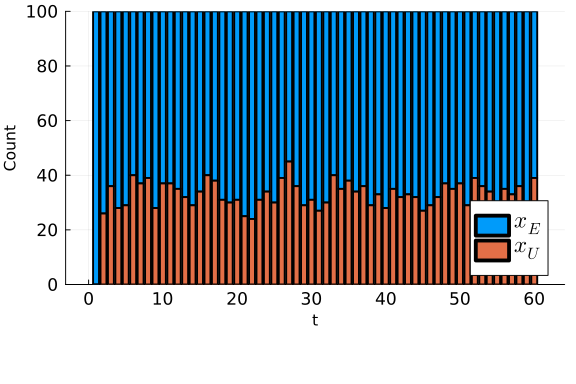

In [1]:
unique_values = unique(X_values)
counts = [sum(X_values[:, t] .== val) for
          val in unique_values, t in 1:T]
# Create the stacked bar chart
groupedbar(1:T, counts';
           bar_position = :stack,
           xlabel="t", ylabel="Count",
           label = [L"x_E" L"x_U"],
           size=(600, 400))

## Simulating with QuantEcon packages

In [1]:
alpha, lambda = 0.3, 0.6
P = [1-alpha alpha; lambda 1-lambda]
mc = MarkovChain(P)
T = 1000
init=1 # initial condition
# using QuantEcon.jl
X = simulate(mc, T;init)
prop_E = sum(X .== 1)/length(X)
println("Prop in E = $prop_E");

Prop in E = 0.661

# Transitions and Expectations

## Probability Mass Functions (PMF)

-   Let the PMF of $X_t$ be given by a row vector $$
    \pi_t \equiv \begin{bmatrix}\mathbb{P}(X_t = x_1) &\ldots & \mathbb{P}(X_t = x_N)\end{bmatrix}
    $$
    -   $\pi_{ti}\geq 0$ for all $i=1,\ldots N$ and
        $\sum_{i=1}^N \pi_{ti} = 1$
    -   Using $\pi_t$ a row vector for convenience
-   If the initial state is known at $t=0$ then $\pi_0$ might be
    degenerate
    -   e.g., if $\mathbb{P}(X_0 = E) = 1$ then
        $\pi_0 = \begin{bmatrix}1 & 0\end{bmatrix}$

## Conditional Forecasts

-   Many macro questions involve:
    $\mathbb{P}(X_{t+j} = x_i | X_t = x_j)$ etc.

-   The transition matrix makes it very easy to forecast the evolution
    of the distribution. Without proof, given $\pi_t$ initial condition

    $$
    \begin{bmatrix}\mathbb{P}(X_{t+1} = x_1) &\ldots & \mathbb{P}(X_{t+1} = x_N)\end{bmatrix} \equiv \pi_{t+1} = \pi_t P
    $$

-   Inductively: for the matrix power (i.e. $P \times P\times \ldots P$,
    not pointwise)

    $$
    \begin{bmatrix}\mathbb{P}(X_{t+j} = x_1) &\ldots & \mathbb{P}(X_{t+j} = x_N)\end{bmatrix} \equiv \pi_{t+j} = \pi_t P^j
    $$

## Conditional Expectations

-   Given the conditional probabilities, expectations are easy

-   Now assign $X_t$ as a random variable with values $x_1, \ldots x_N$
    and pmf $\pi_t$

-   Define $G \equiv \begin{bmatrix}x_1 & \ldots & x_N\end{bmatrix}$

-   From definition of conditional expectations, where $X_t\sim \mu_t$

    $$
    \mathbb{E}[X_{t+j} \,|\, X_t] = \sum_{i=1}^N x_i \pi_{t+j,i} = G \cdot (\pi_t  P^j) = G (\pi_t  P^j)^{\top}
    $$

-   This works for **enormous** numbers of states $N$, as long as $P$ is
    sparse (i.e., the number of elements of $P$ is significant)

## Example: Expected Income

-   Define incomes in E and U states as
    -   $G \equiv \begin{bmatrix}100,000 & 20,000\end{bmatrix}$
    -   Maintain $\mathbb{P}(X_0 = E) = 1$, or
        $\pi_0 = \begin{bmatrix} 1 & 0 \end{bmatrix}$
-   Expected income in 20 periods is then

$$
  \mathbb{E}[X_{20} \,|\, X_0 = x_E] = G \cdot (\pi_0  P^{20})
  $$

## Reminder: PDV for Linear State Space Models

-   If $x_{t+1} = A x_t + C w_{t+1}$ and $y_t = G x_t$ then, $$
    \begin{aligned}
    p(x_t) &= \mathbb{E}\left[\sum_{j=0}^{\infty} \beta^j y_{t+j} \big| x_t\right]\\
    &= G (I - \beta A)^{-1} x_t
    \end{aligned}
    $$
-   Relabel Markov Chains to match the algebra:
    $x \equiv \pi^{\top}, A \equiv P^{\top}, C=0$

## Expected Present Discounted Value

-   Consider an asset with period payoffs in $x_1,\ldots x_N$ with
    transitions according to $P$
-   Risk-neutral **expected present discounted value(EPDV)** $$
    \begin{aligned}
    p(X_t) &= \mathbb{E}\left[\sum_{j=0}^N \beta^j X_{t+j}\,\big|\,X_t\right]\\
    &= \sum_{j=0}^N \beta^j \underbrace{\mathbb{E}\left[X_{t+j}\,\big|\,X_t\right]}_{ =G\left(\pi_t P^j\right)^{\top}}\\
    &= G(I - \beta P^{\top})^{-1} \pi_t^{\top}
    \end{aligned}
    $$
    -   Note the connection to the LSS

# Stationarity and Ergodicity

## Stationary Distribution

-   Take some $X_t$ initial condition, does this converge?

    $$
    \lim_{j\to\infty} X_{t+j}\,|\,X_t = \lim_{j\to\infty} \pi_t \cdot P^j = \pi_{\infty}?
    $$

    -   Does it exist? Is it unique?

-   How does it compare to fixed point below, i.e. does
    $\pi^{*} = \pi_{\infty}$ for all $X_t$?

    $$
    \pi^{*} = \pi^{*} \cdot P
    $$

    -   This is the eigenvector associated with the eigenvalue of $1$ of
        $P^{\top}$
    -   Can prove there is always at least one. If more than one,
        multiplicity

## Stochastic Matrices

-   $P$ is a [stochastic
    matrix](https://en.wikipedia.org/wiki/Stochastic_matrix) if
    -   $\sum_{j=1}^N P_{ij} = 1$ for all $i$, e.g. rows are conditional
        distributions
-   **Key Properties:**
    -   One (or more) eigenvalue of $1$ with associated left-eigenvector
        $\pi$ $$
        \pi P = \pi
        $$
    -   Equivalently the right eigenvector with eigenvalue $=1$ $$
        P^{\top}\pi^{\top} = 1 \times \pi^{\top}
        $$
    -   Where we can normalize to $\sum_{n=1}^N \pi_i = 1$

## Calculating Stationary Distributions

-   Compare the steady states
    -   Left-eigenvector: $\pi^{*} = \pi^{*} P$ (calculate with
        right-eigenvector $1\times \pi^{*\top} = P^{\top}\pi^{*\top}$)
    -   Limiting distribution: $\lim_{T\to\infty}\pi_0 P^T$
-   Can show that the stationary distribution is
    $\pi^{*} = \begin{bmatrix}\frac{\lambda}{\alpha+\lambda} & \frac{\alpha}{\alpha+\lambda}\end{bmatrix}$

In [1]:
eigvals, eigvecs = eigen(P')
index = findfirst(x -> isapprox(x, 1), eigvals)
pi_star = real.(vec(eigvecs[:, index]))
pi_star = pi_star / sum(pi_star)
pi_0 = [1.0, 0.0]
pi_inf = pi_0' * (P^100) # \approx infty?
println("pi_star = ", pi_star)
println("pi_inf = ", pi_inf);

pi_star = [0.6666666666666666, 0.3333333333333333]
pi_inf = adjoint([0.6666666666666629, 0.33333333333333154])

## Communicating States

-   Consider two states $X_i$ and $X_j$ ordered by indices $i$ and $j$
    in $P$,

-   If it is possible to move from $X_i$ to $X_j$ in a finite number of
    steps, the states are said to **communicate**

-   Formally, $X_i$ and $Y_j$ communicate if there exist $l$ and $m$
    such that

    $$
    P^l_{ij} > 0 \quad \text{and} \quad P^m_{ji} > 0
    $$

    -   Consider transition probabilities to see why this implies
        communication

## Irreducibility

-   A Markov chain is **irreducible** if all states communicate with
    each other
-   Calculated in practice with tools such as [strongly connected
    components](https://en.wikipedia.org/wiki/Strongly_connected_component)
    from Graph Theory

In [1]:
mc = MarkovChain(P)
@show is_irreducible(mc);

is_irreducible(mc) = true

## Example: Not-Irreducible

<figure class=''>

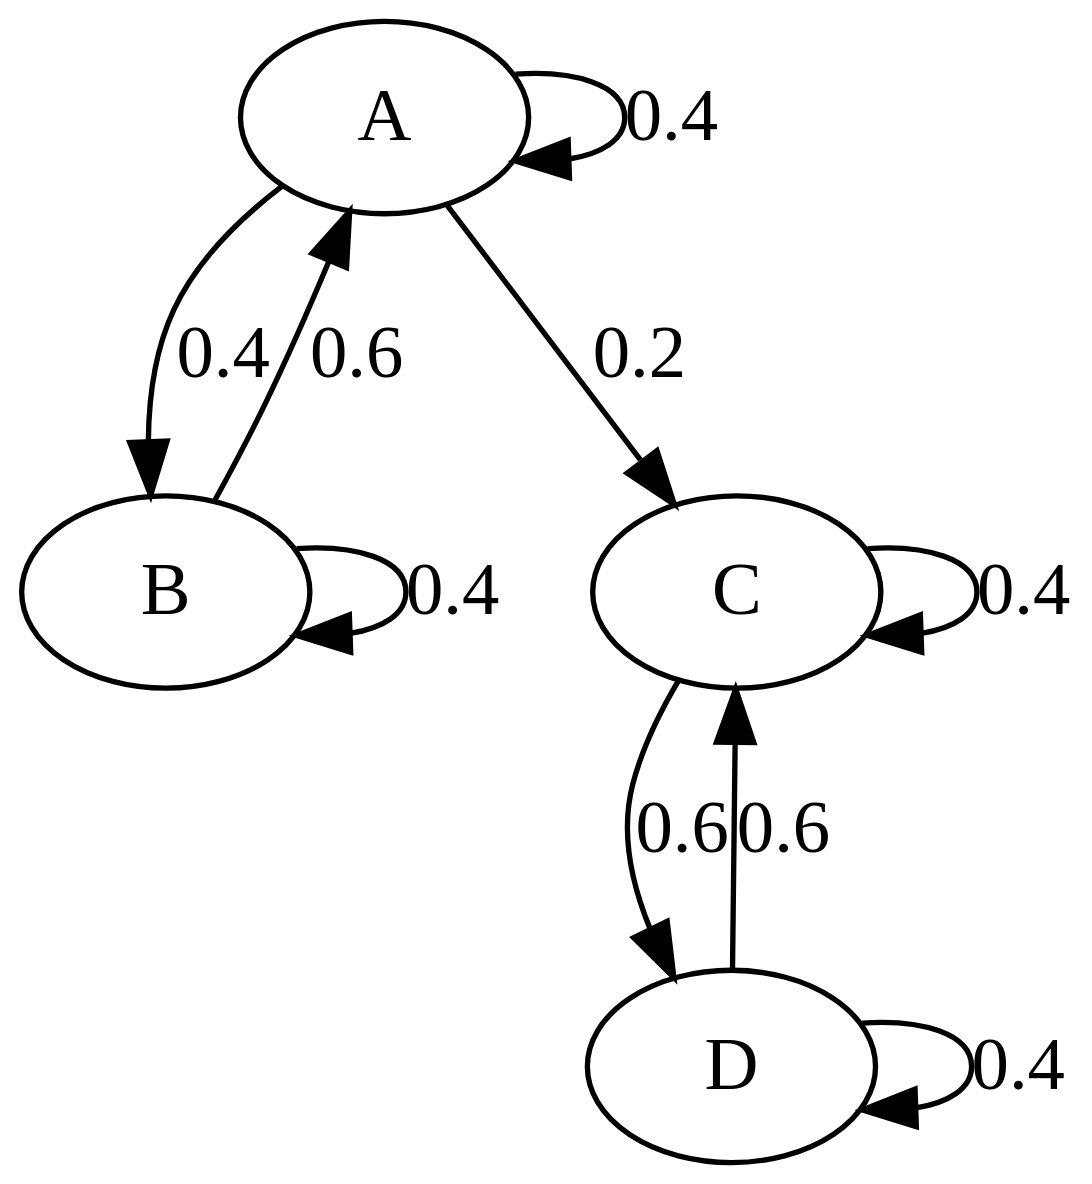

</figure>

``` julia
P2 = [0.4 0.4 0.2 0.0;
     0.6 0.4 0.0 0.0;
     0.0 0.0 0.4 0.6;
     0.0 0.0 0.6 0.4]
mc2 = MarkovChain(P2)
@show is_irreducible(mc2);
```

    is_irreducible(mc2) = false

## Periodicity

-   Loosely speaking, a Markov chain is called periodic if it cycles in
    a predictable way, and aperiodic otherwise
-   See
    [here](https://en.wikipedia.org/wiki/Discrete-time_Markov_chain#Periodicity)
    for more details
    -   The “period” is the greatest common divisor of the set of times
        at which the chain can return to a state

In [1]:
mc = MarkovChain(P)
@show is_aperiodic(mc);

is_aperiodic(mc) = true

## Example: Aperiodic

<figure class=''>

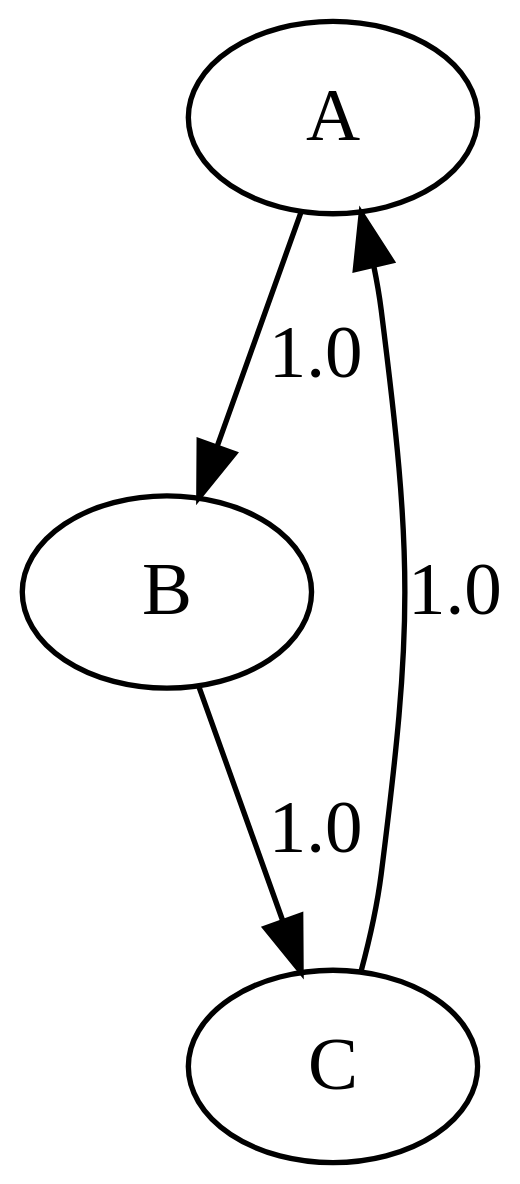

</figure>

``` julia
P3 = [0 1 0; 0 0 1; 1 0 0]
mc3 = MarkovChain(P3)
@show is_aperiodic(mc3);
```

    is_aperiodic(mc3) = false

## Theorems for Stationarity

-   **Theorem** Every stochastic matrix $P$ has at least one stationary
    distribution.
-   **Theorem** If $P$ is irreducible and aperiodic then
    -   it has a unique stationary distribution $\pi^{*}$
    -   for any initial distribution $\pi_0$,
        $\lim_{T\to\infty}\pi_0 P^T = \pi^{*}$
    -   $P_{ij} > 0$ for all $i,j$ is a sufficient condition
    -   it is **ergodic**. With $\mathbb{1}\{\cdot\}$ the indicator
        function $$
        \lim_{T\to\infty} \frac{1}{T} \sum_{t=1}^T \mathbb{1}\{X_t = x_i\} = \pi^{*}_i, \quad \text{for all }i
        $$

## Ergodicity

-   These is the same sense of **ergodicity** we discussed
    [before](https://jlperla.github.io/ECON408/lectures/stochastic_dynamics.html#/ergodicity)


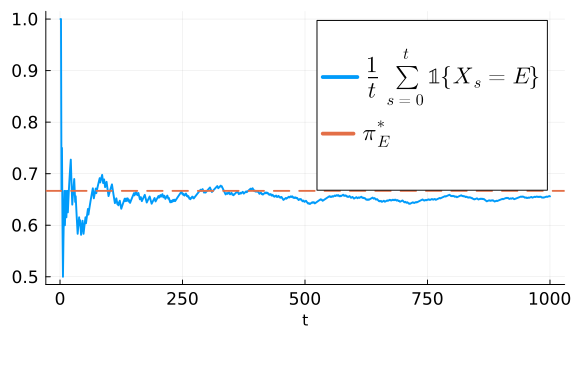

In [1]:
alpha, lambda = 0.3, 0.6
P = [1-alpha alpha; lambda 1-lambda]
mc = MarkovChain(P)
pi_star = stationary_distributions(mc)[1]
T = 1000
init=1
X = simulate(mc, T;init)
prop_E_t = cumsum(X.==1)./(1:length(X))
plot(1:T, prop_E_t, xlabel="t",
 label=L"\frac{1}{t}\sum_{s=0}^t \mathbb{1}\{X_s=E\}",
 size=(600, 400))
hline!([pi_star[1]]; label=L"\pi^{*}_E",
linestyle=:dash)

# Discretizing Continuous State Processes

## Discretization

-   Unless continuous variables are easily summarized by a finite number
    of parameters or statistics, we will need to convert continuous
    functions and stochastic processes into discrete ones.
-   Hence, to implement many algorithms, it is useful to model decisions
    with a finite number of states
    -   If the natural stochastic process is discrete, then no problem
    -   Otherwise, you can **discretize** the continuous time process
        into $N$ states
    -   Try to ensure crucial statistics are preserved
    -   $N$ might be very large!

## AR(1) Transition Probabilities

e.g. $X_{t+1} = \rho X_t + \sigma w_{t+1}$ using [Tauchen’s
Method](https://julia.quantecon.org/introduction_dynamics/finite_markov.html#exercise-3)

(X_vals[1], X_vals[end]) = (-1.2500000000000002, 1.2500000000000002)


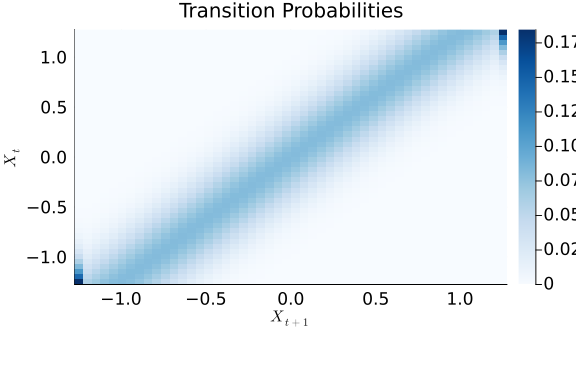

In [1]:
N = 50 # number of nodes
rho = 0.8
sigma = 0.25
mc = tauchen(N, rho, sigma)
X_vals = mc.state_values
@show X_vals[1], X_vals[end]
heatmap(X_vals, X_vals, mc.p;
        xlabel=L"X_{t+1}",
        ylabel=L"X_{t}",
        title="Transition Probabilities",
        color=:Blues,
        size=(600, 400))

## Simulation


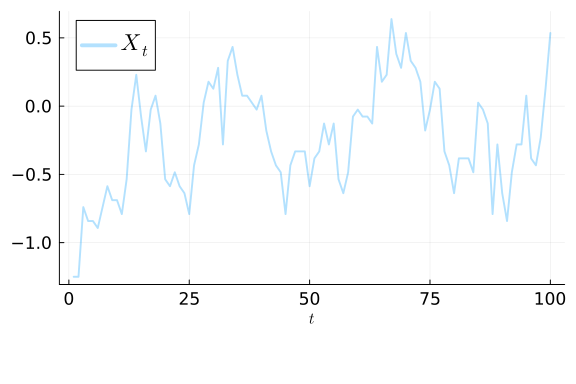

In [1]:
T = 100
X = simulate(mc, T;init=1)
plot(X, xlabel=L"t", label=L"X_t",
     alpha = 0.3, size=(600, 400))

## Ensemble


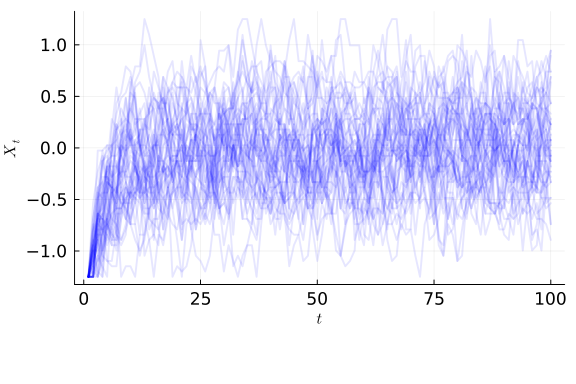

In [1]:
T = 100
num_chains = 50
plt = plot(;ylabel=L"X_t", xlabel=L"t",
           size=(600, 400), legend=false)
for i in 1:num_chains
    X = simulate(mc, T;init=1)
    plot!(X; alpha = 0.1, color=:blue)
end
plt

# Lake Model of Unemployment and Employment

## Individual Worker

-   Consider a worker who can be either employed ($E$) or unemployed
    ($U$), following our previous markov chain
-   Assign the value of $0$ if unemployed and $1$ if employed
-   Lets calculate the cumulative proportion of their time employed

## Reminder on Long-Run

-   What is the probability in the distant future of being employed?
-   Note ergodic interpretation!

In [1]:
lambda = 0.283
alpha = 0.013
T = 5000
# order U, E
P = [1-lambda lambda; alpha 1-alpha]
mc = MarkovChain(P)
@show stationary_distributions(mc)[1]
eigvals, eigvecs = eigen(P')
index = findfirst(x -> isapprox(x, 1), eigvals)
pi_star = real.(vec(eigvecs[:, index]))
pi_star = pi_star / sum(pi_star)
@show pi_star;

(stationary_distributions(mc))[1] = [0.043918918918918914, 0.956081081081081]
pi_star = [0.04391891891891895, 0.9560810810810811]

## Cumulative Employment


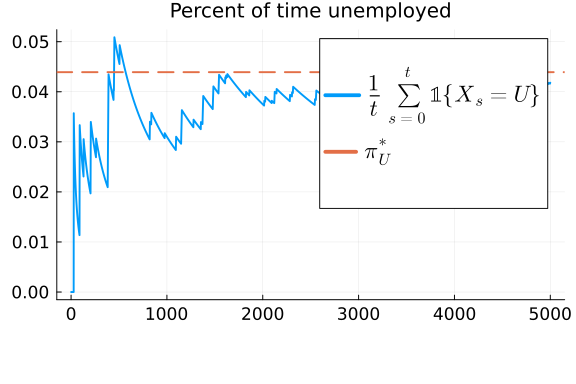

In [1]:
mc = MarkovChain(P, [0; 1])  # U -> 0, E -> 1
s_path = simulate(mc, T; init = 2)
u_bar, e_bar = stationary_distributions(mc)[1]
# Note mapping in MarkovChain
s_bar_e = cumsum(s_path) ./ (1:T)
s_bar_u = 1 .- s_bar_e
s_bars = [s_bar_u s_bar_e]
plot(title = "Percent of time unemployed",
 1:T, s_bars[:, 1], lw = 2,
 label=L"\frac{1}{t}\sum_{s=0}^t \mathbb{1}\{X_s = U\}",
 legend=:topright, size=(600, 400))
hline!([u_bar], linestyle = :dash,
       label = L"\pi^{*}_U")

## Many Workers

-   Consider if an entire economy is populated by workers of these types
-   With approximately a continuum of agents of this type, can we
    interpret the statistical distribution of the states as a fraction
    in the distribution?
-   This is a key trick used throughout macro, but is subtle
-   We will assume a continuum of agents, but add in:
    -   A proportion $d$ die each period
    -   A proportion $b$ are born each period (into the $U$ state)
    -   Define $g\equiv b-d$, the net growth rate

## Definitions

-   To track distributions, a tight connection to the “adjoint” of the
    stochastic process for the Markov Chain

-   Instead, building it directly from flows, define

    -   $E_t$, the total number of employed workers at date $t$
    -   $U_t$, the total number of unemployed workers at $t$
    -   $N_t$, the number of workers in the labor force at $t$
    -   The employment rate $e_t \equiv E_t/N_t$.
    -   The unemployment rate $u_t \equiv U_t/N_t$.

## Laws of Motion for Stock Variables

-   Of the mass of workers $E_t$ who are employed at date $t$,

    -   $(1-d)E_t$ remain in $N_t$, and $(1-\alpha)(1-d)E_t$ remain in
        $E_t$

    $$
    E_{t+1} = (1-d)(1-\alpha)E_t + (1-d)\lambda U_t
    $$

-   Of the mass of workers $U_t$ workers who are currently unemployed,

    -   $(1-d)U_t$ will remain in $N_t$ and $(1-d) \lambda U_t$ enter
        $E_t$

    $$
    U_{t+1} = (1-d)\alpha E_t + (1-d)(1-\lambda)U_t + b (E_t+U_t)
    $$

-   The total stock of workers $N_t=E_t+U_t$ evolves as

    $$
    N_{t+1} = (1+b-d)N_t = (1+g)N_t
    $$

## Summarizing

-   Letting $X_t \equiv \begin{bmatrix}U_t\\E_t\end{bmatrix}$, the law
    of motion for $X$ is

    $$
    X_{t+1} = \underbrace{\begin{bmatrix}
        (1-d)(1-\lambda) + b & (1-d)\alpha + b  \\
        (1-d)\lambda & (1-d)(1-\alpha)
    \end{bmatrix}}_{\equiv A} X_t
    $$

    -   Note:
        $A = (1-d) P^{\top} + \begin{bmatrix}b & b\\0 & 0\end{bmatrix}$
    -   Take a class in stochastic processes!

## Laws of Motion for Rates

-   Define
    $x_t \equiv \begin{bmatrix}u_t\\e_t\end{bmatrix} = \begin{bmatrix}U_t/N_t\\E_t/N_t\end{bmatrix}$

-   Divide both sides of $X_{t+1} = A X_t$ by $N_{t+1}$ and simplify to
    get $$
      x_{t+1} = \underbrace{\frac{1}{1 + g} A}_{\equiv \hat{A}} x_t
      $$

    -   You can check that $e_t + u_t = 1$ implies that
        $e_{t+1}+u_{t+1} = 1$

## Longrun Distribution

-   To find the long-run distribution of employment rates note, $$
    x^{*} = \hat{A} x^{*} = h(x^{*})
    $$
    -   So could ,find a fixed point of $h(\cdot)$
    -   Or solve an eigenvalue problem.
-   Note that if $g \neq 0$, there is no fixed point of
    $X_{t+1} = A X_t$

## Reminder: Simple Function Iteration

In [1]:
function iterate_map(f, x0, T)
    x = zeros(length(x0), T + 1)
    x[:, 1] = x0
    for t in 2:(T + 1)
        x[:, t] = f(x[:, t - 1])
    end
    return x
end

## Implementation of a Lake Model

In [1]:
function lake_model(; lambda = 0.283, alpha = 0.013, b = 0.0124, d = 0.00822)
    g = b - d
    A = [(1 - lambda) * (1 - d)+b (1 - d) * alpha+b
         (1 - d)*lambda (1 - d)*(1 - alpha)]
    A_hat = A ./ (1 + g)
    x_0 = ones(size(A_hat, 1)) / size(A_hat, 1)
    sol = fixedpoint(x -> A_hat * x, x_0)
    converged(sol) || error("Failed to converge in $(sol.iterations) iter")    
    x_bar =sol.zero
    return (; lambda, alpha, b, d, A, A_hat, x_bar)
end

## Aggregate Dynamics


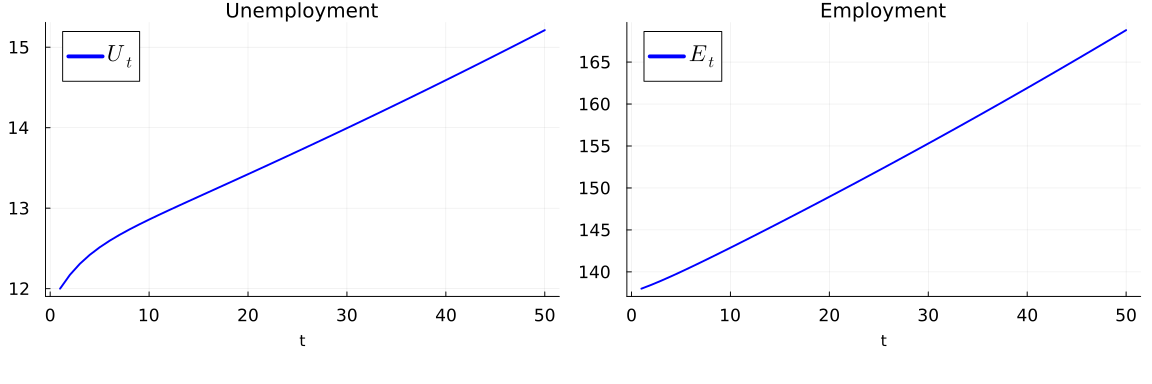

In [1]:
lm = lake_model()
N_0 = 150
e_0 = 0.92
u_0 = 1 - e_0
T = 50
U_0 = u_0 * N_0
E_0 = e_0 * N_0
X_0 = [U_0; E_0]
X_path = iterate_map(X -> lm.A * X, X_0, T - 1)
x1 = X_path[1, :]
x2 = X_path[2, :]
plt_unemp = plot(1:T, X_path[1, :]; color = :blue,
                 label = L"U_t", xlabel="t", title = "Unemployment")
plt_emp = plot(1:T, X_path[2, :]; color = :blue,
               label = L"E_t", xlabel="t", title = "Employment")
plot(plt_unemp, plt_emp, layout = (1, 2), size = (1200, 400))

## Transitions of Rates


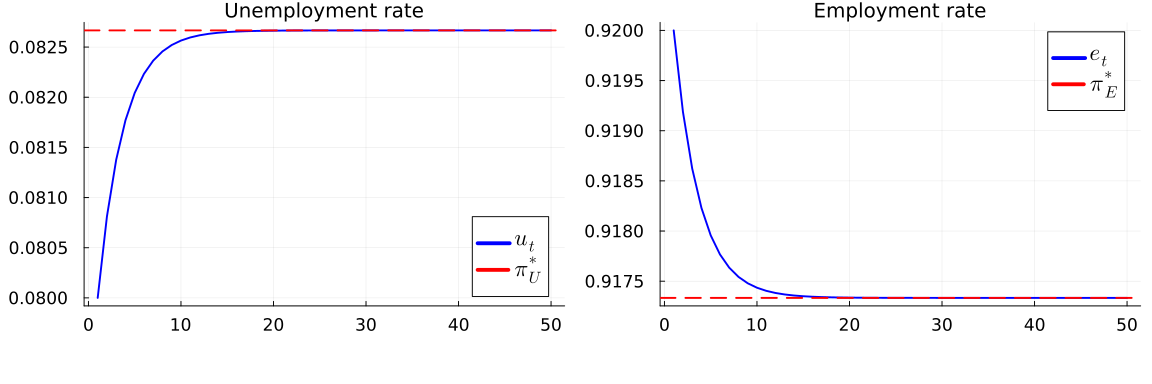

In [1]:
u_bar, e_bar = lm.x_bar
x_0 = [u_0; e_0]
x_path = iterate_map(x -> lm.A_hat * x, x_0, T - 1)
plt_unemp = plot(1:T, x_path[1, :];title = "Unemployment rate", 
                 color = :blue, label = L"u_t")
hline!(plt_unemp, [u_bar], color = :red, linestyle = :dash, label = L"\pi^{*}_U")
plt_emp = plot(1:T, x_path[2, :]; title = "Employment rate", color = :blue, label = L"e_t")
hline!(plt_emp, [e_bar], color = :red, linestyle = :dash,label = L"\pi^{*}_E")
plot(plt_unemp, plt_emp, layout = (1, 2), size = (1200, 400))